## Tweet Emotion Recoginition: NLP using TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp 
import random

In [2]:
def show_history(h):
    epochs_trained =len(h.history['loss'])
    plt.figure(figsize=(16,6))
    
    plt.subplot(1,2,1)
    plt.plot(range(0, epochs_trained),h.history.get('Accuracy'),label='Training')
    plt.plot(range(0, epochs_trained),h.history.get('val_Accuracy'), label='Validation')
    plt.ylim([0.,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(0,epochs_trained),h.history.get('loss'),label='Training')
    plt.plot(range(0,epochs_trained),h.history.get('val_loss'), label='Valdation')
    #plt.ylim([0.,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [3]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm= confusion_matrix(y_true, y_pred,normalize='true')
    
    plt.figure(figsize=(8,8))
    sp=plt.subplot(1,1,1)
    ctx=sp.matshow(cm)
    plt.xticks(list(range(0,6)),labels=classes)
    plt.yticks(range(0,6), labels=classes)
    plt.colorbar(ctx)
    plt.show()


## Importing Data
1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [5]:
print(dataset)

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}


In [6]:
train=dataset['train']
test=dataset['test']
val=dataset['validation']

In [7]:
def get_tweet(data):
    tweets=[x['text'] for x in data]
    labels=[x['label'] for x in data]
    return tweets,labels

In [8]:
tweets,labels=get_tweet(train)

In [9]:
tweets[3],labels[3]

('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'love')

## Tokenizer
**Tokenizing the tweets**

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

We are go to give to each unique word to unique token.

In [11]:
tokenizer = Tokenizer(num_words= 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

## Padding and Truncating Sequences
1. Checking length of the tweets
2. Creating padding sequences

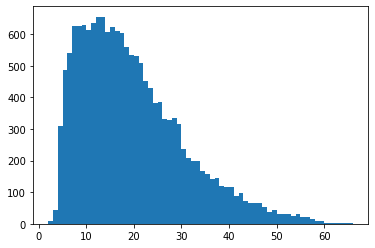

In [14]:
lengths=[len(t.split(' ')) for t in tweets]
# we can ignore the bins
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [15]:
max_len = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer,tweets):
    sequence = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequence, truncating ='post',padding='post', maxlen=max_len)
    return padded

In [17]:
padded_train_set=get_sequences(tokenizer,tweets)

In [18]:
padded_train_set[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Preparing the Labels
1. Creating classes to index and index to classes dictionaries
2. Converting the text labes to numerical labels

In [19]:
classes=set(labels)
print(classes)

{'love', 'surprise', 'sadness', 'fear', 'anger', 'joy'}


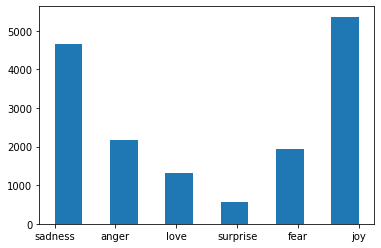

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
class_to_index= dict((c,i) for i, c in enumerate(classes))
index_to_class= dict((v,k) for k, v in class_to_index.items())

In [22]:
class_to_index

{'love': 0, 'surprise': 1, 'sadness': 2, 'fear': 3, 'anger': 4, 'joy': 5}

In [23]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'sadness', 3: 'fear', 4: 'anger', 5: 'joy'}

In [24]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Creating the Model
1. Creating the model
2. Compiling the model

In [26]:
from keras import layers

In [27]:
model= tf.keras.models.Sequential([
    layers.Embedding(10000,16, input_length= max_len),
    layers.Bidirectional(layers.LSTM(20, return_sequences= True)),
    layers.Bidirectional(layers.LSTM(20)),
    layers.Dense(6, activation='softmax'),
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['Accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model
1. Preparing a validation set
2. Training the model

In [29]:
val_tweets, val_labels= get_tweet(val)
val_seq= get_sequences(tokenizer,val_tweets)
val_labels= names_to_ids(val_labels)

In [30]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [31]:
val_seq[0]

array([ 17,   8, 157, 260,   4, 343,  16,  51,  19, 212,   1,  50,  10,
        13, 533,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [32]:
h=model.fit(
    padded_train_set,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_Accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 30s 43ms/step - loss: 1.3555 - Accuracy: 0.4699 - val_loss: 1.0616 - val_Accuracy: 0.5955
Epoch 2/20
500/500 [==============================] - 23s 45ms/step - loss: 0.7596 - Accuracy: 0.7096 - val_loss: 0.5796 - val_Accuracy: 0.8035
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 0.3498 - Accuracy: 0.8846 - val_loss: 0.4700 - val_Accuracy: 0.8500


## Evaluation the Model
1. Visualizing training history
2. Prepraing a test set
3. A look at individual predictions on the test set
4. A look at all prediction on the test set

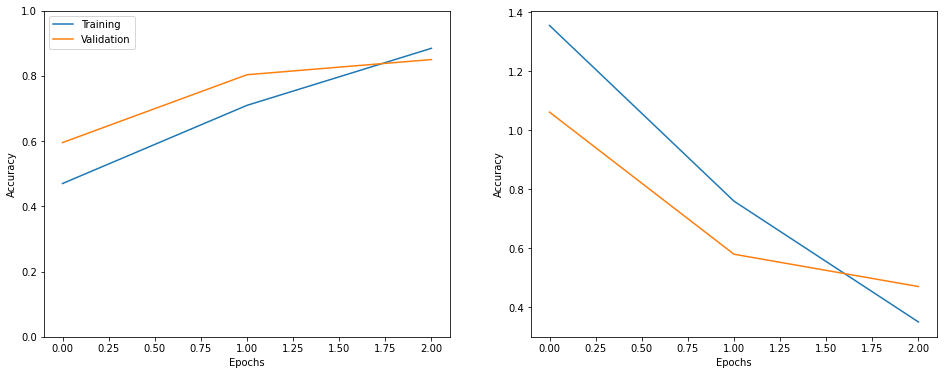

In [33]:
show_history(h)

In [34]:
test_tweets, test_labels= get_tweet(test)
test_seq= get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [35]:
test_tweets[0],test_labels[0]

('im feeling rather rotten so im not very ambitious right now', 2)

In [36]:
y=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 17ms/step - loss: 0.4618 - Accuracy: 0.8440


In [37]:
i=random.randint(0,len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel appalled right now
Emotion: anger
Predicted Emotion: anger


In [38]:
preds= model.predict(test_seq)

In [39]:
print(p)
np.argmax(p)

[1.4922673e-04 1.6403629e-04 1.6009305e-01 3.4767254e-03 8.1830209e-01
 1.7814802e-02]


4

In [40]:
y_preds= np.zeros(len(test_labels))

j=0;
for k in preds:
    y_preds[j]=np.argmax(k)
    j=j+1;
y_preds

array([2., 2., 2., ..., 5., 5., 3.])

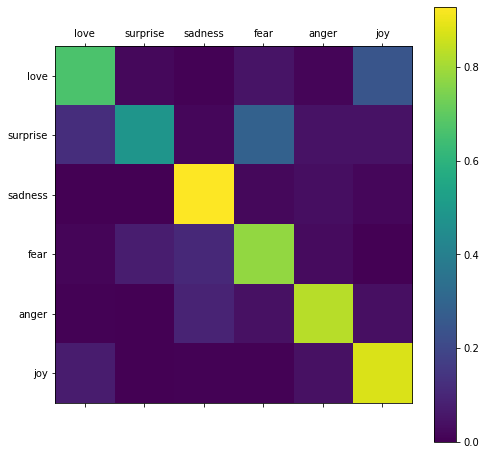

In [41]:
show_confusion_matrix(test_labels,y_preds,list(classes))